<a href="https://colab.research.google.com/github/pbannuru/NLP-Basic_STUFF/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding,Activation,Dropout,LSTM
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D
import numpy as np 
from numpy import array 
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from wordcloud import WordCloud
import nltk,re
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
fake=pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [7]:
fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [29]:
real=pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [5]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

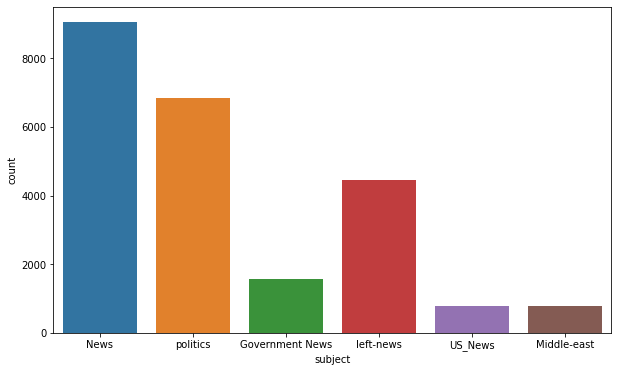

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

In [10]:
# Wordcloud

In [16]:
text=' '.join(fake['text'].tolist())

In [21]:
wordcloud=WordCloud(width=1920,height=1000).generate(text)

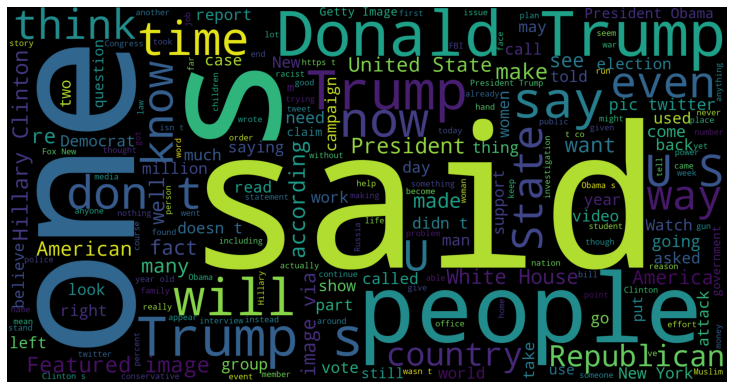

In [22]:
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')  
plt.tight_layout(pad=0)
plt.show()

In [23]:
real['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [24]:
text=' '.join(real['text'].tolist())

In [25]:
wordcloud=WordCloud(width=1920,height=1000).generate(text)

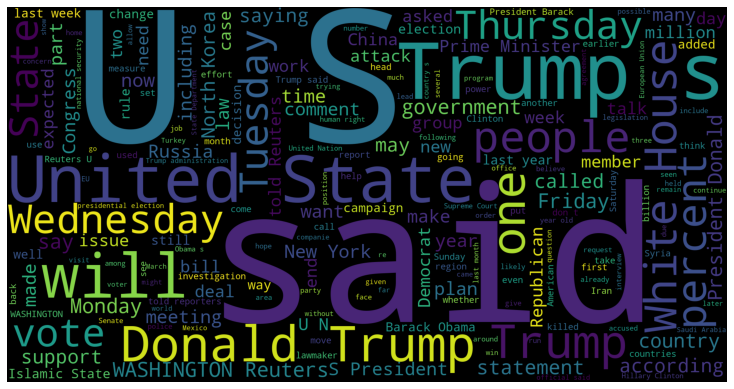

In [26]:
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')  
plt.tight_layout(pad=0)
plt.show()

# difference in texxt:
1. some texts are ttweets from twitter
2. few text do not contain any publication info
3. most of text contains reuters info such as WASHINGTON (Reuters)

In [27]:
# cleaning of data

In [28]:
real.sample(5)

,title,text,subject,date
11635,Russia spurns U.S. allegations it violates nuc...,MOSCOW (Reuters) - U.S. allegations that Russi...,worldnews,"December 21, 2017"
5405,Trump says will issue new order next week to p...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"February 16, 2017"
11724,"Germany takes political vacuum in its stride, ...",BERLIN (Reuters) - Largely unperturbed by Ange...,worldnews,"December 20, 2017"
12186,Erdogan says Turkey seeking to annul Trump dec...,ANKARA (Reuters) - Turkey is launching an init...,worldnews,"December 15, 2017"
3805,Interviews for new FBI director to start as ea...,WASHINGTON (Reuters) - The Department of Justi...,politicsNews,"May 12, 2017"


In [45]:
unknown_publishers=[]
for index,row in enumerate(real.text.values):
  try:
    record=row.split(' - ', maxsplit=1)
    record[1]

    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [46]:
len(unknown_publishers)

228

In [47]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 228, dtype: object

In [43]:
real=real.drop(8970,axis=0)

In [48]:
publisher = []
temp_text = []
for index,row in enumerate(real.text.values):
  if index in unknown_publishers:
    temp_text.append(row)
    publisher.append('unknown')
  else:
    record=row.split(" - ", maxsplit=1)
    publisher.append(record[0].strip())
    temp_text.append(record[1].strip())

In [49]:
real['publisher']=publisher 
real['text']=temp_text

In [50]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [51]:
real.shape

(21416, 5)

In [53]:
empty_fake_index=[index for index,text in enumerate(fake.text.tolist()) if str(text).strip()=='']

In [54]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [56]:
real['text']=real['title']+' '+real['text']
fake['text']=fake['title']+' '+fake['text']

In [57]:

real['text']=real['text'].apply(lambda x: str(x).lower())
fake['text']=fake['text'].apply(lambda x: str(x).lower())

In [60]:
real['class']=1
fake['class']=0

In [61]:
real=real[['text','class']]

In [62]:
fake=fake[['text','class']]

In [64]:
data=real.append(fake,ignore_index=True)

In [65]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.4 MB 15.8 MB/s 
     |████████████████████████████████| 208 kB 49.5 MB/s 
     |████████████████████████████████| 2.2 MB 54.9 MB/s 
     |████████████████████████████████| 3.7 MB 49.7 MB/s 
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.5
    Uninstalling srsly-2.4.5:
      Successfully uninstalled srsly-2.4.5
  Attempting uninstall: blis
    Found existing installation: blis 0.7.9
    Uninstalling blis-0.7.9:
      Successfully uninstalled blis-0.7.9
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.5
    Uninstalling thinc-8.1.5:
      Successfully uninstalled thinc-8.1.5
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: spacy
    Found existing installation: s

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 29.5 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011739 sha256=c8cc214b881200fbadcc64ecc00fa00296bb4677cc8a490830a18beeab8a1dcc
  Stored in directory: /tmp/pip-ephem-wheel-cache-szsyqyqx/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.4.1
    Uninstalling en-core-web-sm-3.4.1:
      Successfully uninstalled en-core-web-sm-3.4.1
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 32.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: b

In [69]:
data['text']=data['text'].apply(lambda x: re.sub('[^a-z A-Z 0-9]+','',x))

In [70]:
#word2vec:

In [72]:
data['text']

0        as us budget fight looms republicans flip thei...
1        us military to accept transgender recruits on ...
2        senior us republican senator let mr mueller do...
3        fbi russia probe helped by australian diplomat...
4        trump wants postal service to charge much more...
                               ...                        
44892    mcpain john mccain furious that iran treated u...
44893    justice yahoo settles email privacy classactio...
44894    sunnistan us and allied safe zone plan to take...
44895    how to blow 700 million al jazeera america fin...
44896    10 us navy sailors held by iranian military  s...
Name: text, Length: 44897, dtype: object

In [73]:
import gensim

In [74]:
y=data['class'].values

In [77]:
X=[d.split() for d in data['text'].tolist()]

In [78]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'fede

In [80]:
DIM=100
w2v_model=gensim.models.Word2Vec(sentences=X,size=DIM,window=10,min_count=1)

In [81]:
w2v_model['love']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 5.2096331e-01, -2.4141948e+00, -2.6493492e+00, -2.4283547e+00,
        1.0508831e+00, -2.9429953e+00, -1.5331142e+00,  9.6265918e-01,
       -2.0704768e+00, -9.5734584e-01,  1.4481041e+00, -2.6132174e+00,
       -1.9850171e+00, -5.5876732e-01, -2.8159723e+00,  1.9244652e+00,
        1.8767225e+00, -1.3859118e-02, -9.7478491e-01, -4.3452185e-01,
       -3.1036110e+00,  1.6341100e+00,  1.0120727e+00, -2.2831805e+00,
        1.8682777e+00,  1.7640777e+00,  1.3176459e+00,  1.1313704e+00,
        4.7104278e-01,  2.6418879e+00, -1.6565299e-01,  3.1691086e+00,
       -2.1169305e+00, -4.0505376e+00, -1.8438150e+00,  1.1245872e+00,
        8.4211975e-01,  2.7370772e-01, -1.4204483e+00,  3.1057813e+00,
       -2.5179172e-01, -1.9799787e+00, -1.8491049e+00,  7.9459101e-02,
       -1.6488905e+00,  1.7738342e+00, -2.3328037e+00, -1.4817090e+00,
       -1.6869664e+00, -2.4481645e+00,  1.9600842e+00,  1.2170058e+00,
       -4.6507468e+00, -1.4937893e+00, -5.8597708e-03, -4.1266701e-01,
      

In [82]:
w2v_model.most_similar('india')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pakistan', 0.7580753564834595),
 ('malaysia', 0.7112585306167603),
 ('modi', 0.6797585487365723),
 ('china', 0.659382700920105),
 ('indian', 0.618323564529419),
 ('australia', 0.610535740852356),
 ('thailand', 0.6092319488525391),
 ('beijing', 0.609096884727478),
 ('indias', 0.6085741519927979),
 ('beijings', 0.6044197082519531)]

In [83]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)

In [84]:
X=tokenizer.texts_to_sequences(X)

In [86]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'trump': 12,
 'he': 13,
 'said': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'not': 23,
 'have': 24,
 'from': 25,
 'at': 26,
 'this': 27,
 'are': 28,
 'us': 29,
 'who': 30,
 'an': 31,
 'they': 32,
 'but': 33,
 'i': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'out': 55,
 'its': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'new': 60,
 'when': 61,
 'also': 62,
 'over': 63,
 'up': 64,
 'house': 65,
 'no': 66,
 'there': 67,
 'donald': 68,
 'clinton': 69,
 'obama': 70,
 'our': 71,
 'states': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'republican': 76,
 'him': 77,
 'than': 78,
 'so': 79,
 'other': 80,
 'so

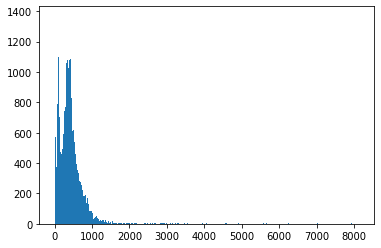

In [91]:
plt.hist([len(x) for x in X],bins=700)
plt.show()

In [92]:
nos=np.array([len(x) for x in X]) 
len(nos[nos>1000])


1627

In [93]:
maxlen=1000
X=pad_sequences(X,maxlen=maxlen)

In [94]:
X

array([[   0,    0,    0, ...,    8,    1,  819],
       [   0,    0,    0, ...,   40, 1977, 2204],
       [   0,    0,    0, ...,   15,   13,   14],
       ...,
       [   2,  791,    9, ...,  983,  265, 2457],
       [   0,    0,    0, ...,  983, 6659,  325],
       [   0,    0,    0, ...,  983,  245, 2457]], dtype=int32)

In [95]:
len(X[100])

1000

In [96]:
vocab_size=len(tokenizer.word_index)+1

In [97]:
vocab=tokenizer.word_index

In [99]:
def get_weight_matrix(model):
  weight_matrix=np.zeros((vocab_size, DIM))
  for word,i in vocab.items():
    weight_matrix[i]=model.wv[word] 
    return weight_matrix

In [100]:
embedding_vectors=get_weight_matrix(w2v_model)

In [102]:
embedding_vectors.shape

(231809, 100)

In [107]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights=[embedding_vectors],input_length=maxlen,trainable=False)) # false as we already trained
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])

In [104]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         23180900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23,298,277
Trainable params: 117,377
Non-trainable params: 23,180,900
_________________________________________________________________


In [113]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [109]:
model.fit(X_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
737/737 [==============================] - 36s 41ms/step - loss: 0.6638 - acc: 0.5901 - val_loss: 0.6592 - val_acc: 0.5966
Epoch 2/6
737/737 [==============================] - 28s 38ms/step - loss: 0.6626 - acc: 0.5950 - val_loss: 0.6580 - val_acc: 0.5929
Epoch 3/6
737/737 [==============================] - 29s 39ms/step - loss: 0.6592 - acc: 0.5888 - val_loss: 0.6563 - val_acc: 0.5969
Epoch 4/6
737/737 [==============================] - 29s 39ms/step - loss: 0.6591 - acc: 0.5955 - val_loss: 0.6728 - val_acc: 0.5974
Epoch 5/6
737/737 [==============================] - 29s 39ms/step - loss: 0.6642 - acc: 0.5921 - val_loss: 0.6592 - val_acc: 0.5966
Epoch 6/6
737/737 [==============================] - 28s 38ms/step - loss: 0.6538 - acc: 0.6018 - val_loss: 0.6592 - val_acc: 0.6040


In [110]:
y_pred=(model.predict(X_text) >=0.5).astype(int)

351/351 [==============================] - 7s 19ms/step


In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59      5925
           1       0.48      0.33      0.39      5300

    accuracy                           0.51     11225
   macro avg       0.50      0.50      0.49     11225
weighted avg       0.51      0.51      0.50     11225



In [128]:
x=['this is a news']
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=maxlen)

In [131]:
(model.predict(x)>=0.5).astype(int)  ### result = fake

1/1 [==============================] - 0s 26ms/step


array([[0]])